# Set Up

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.signal import sepfir2d
import folium
import random
import math
%matplotlib inline

from os import path, getcwd
from glob import glob

code_dir = getcwd()
data_dir = path.expanduser('~/data/workshop-content18/3-snc/data/')

ais_pathnames = glob(data_dir + '*.txt')
ais_basenames = [path.basename(pn) for pn in ais_pathnames]

delta_cur_basename = next(bn for bn in ais_basenames if 'Deltaport_Current' in bn)
delta_his_basename = next(bn for bn in ais_basenames if 'Deltaport_History' in bn)

max_rows=int(3e6)
delta_cur = pd.read_csv(
    data_dir + delta_cur_basename, sep='\t', nrows=max_rows, low_memory=False,
    parse_dates=['ReceivedTime'])

In [90]:
if delta_cur.isna().iloc[-1,:].sum() > 10:
    delta_cur = delta_cur.iloc[:-1, :]

In [91]:
delta_cur.UserID = delta_cur.UserID.astype('category')

In [92]:
delta_cur = delta_cur.loc[delta_cur.Latitude < 80]

In [93]:
nPoints_by_UserID = pd.value_counts(delta_cur.UserID)

In [94]:
nPoints_threshold = 1000
userID_allowed = nPoints_by_UserID.index[nPoints_by_UserID > nPoints_threshold]
userID_allowed.values.remove_unused_categories(inplace=True)

In [95]:
delta_cur = delta_cur.loc[delta_cur.UserID.apply(lambda x: x in userID_allowed.values)]

In [96]:
ReceivedDate = delta_cur.ReceivedTime.dt.date
ReceivedDate_ValueCounts = pd.value_counts(ReceivedDate)
ReceivedDate_ValueCounts.to_frame()

,ReceivedTime
2013-10-23,276045
2013-10-29,267727
2013-10-22,266404
2013-10-27,259420
2013-10-28,253972
2013-10-26,238035
2013-10-30,237996
2013-10-31,237442
2013-10-25,220591
2013-10-24,196405


In [97]:
delta_cur['ReceivedDay'] = ReceivedDate.apply(lambda x: x.day)

In [98]:
sns.set(style="whitegrid", color_codes=True)

In [99]:
df_grp = delta_cur.groupby(['ReceivedDay', 'UserID'])

Let's plot records of ships just on the 22nd

In [100]:
delta_cur_22 = delta_cur.loc[delta_cur.ReceivedDay == 22, :]

# One Ship

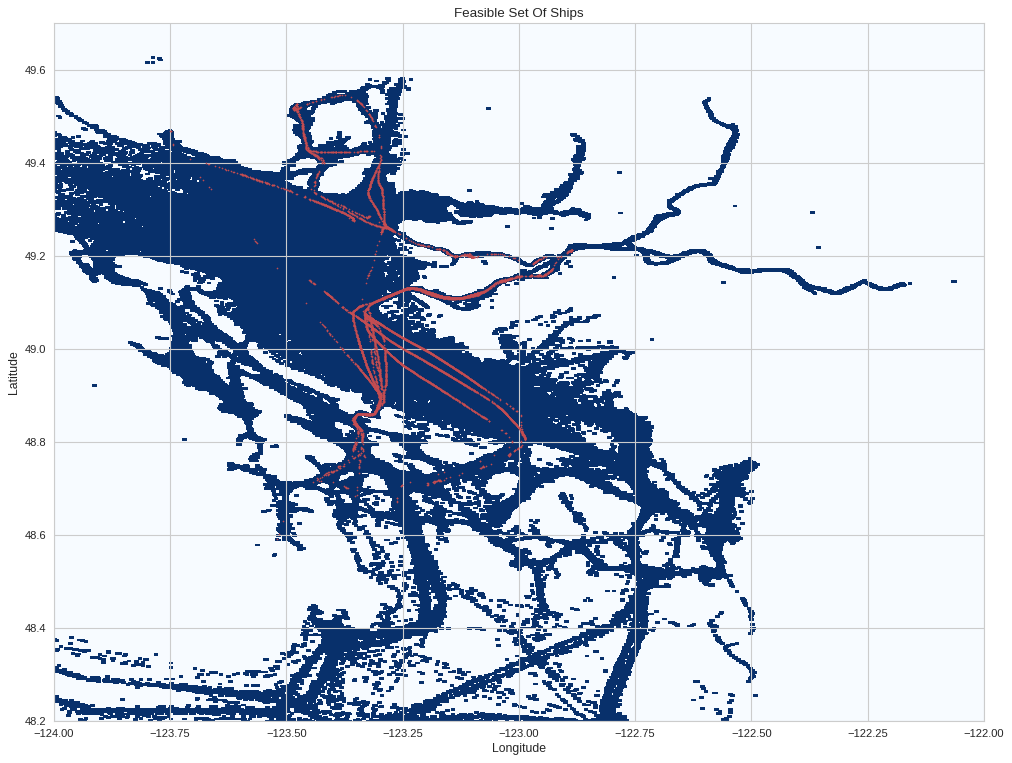

In [110]:
UserID_vc = pd.value_counts(delta_cur.UserID)
#i = random.randint(1,int(UserID_vc.size)) # 117
i = 59
#i = 117
ship = (delta_cur.loc[delta_cur.UserID == UserID_vc.index[i]])

xedges = np.load('xedges.dat')
yedges = np.load('yedges.dat')
H = np.load('FS.dat') # feasible set
H = sepfir2d(H, [1,2,3,5], [1,4,5,6])
H[H>0]=1

x = list(ship.Longitude)
y = list(ship.Latitude)

fig = plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Longitude", ylabel="Latitude", title="Feasible Set Of Ships")
plt.imshow(H, interpolation='nearest', origin='low',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=mpl.cm.Blues)

plt.scatter(x,y, marker='.', color='r', s=5)

In [111]:
ps = list(zip(x,y)) # all points
butfirst = ps[1:] # all points but first
butlast = ps[:-1] # all points but last
lines = list(zip(butlast,butfirst)) # all directed line segments (ship goes from point one to point two)

In [112]:
def length(line):
    return math.sqrt((line[1][0] - line[0][0]) ** 2 + (line[1][0] - line[0][0]) ** 2)


Text(0.5,1,'Length of line intervals')

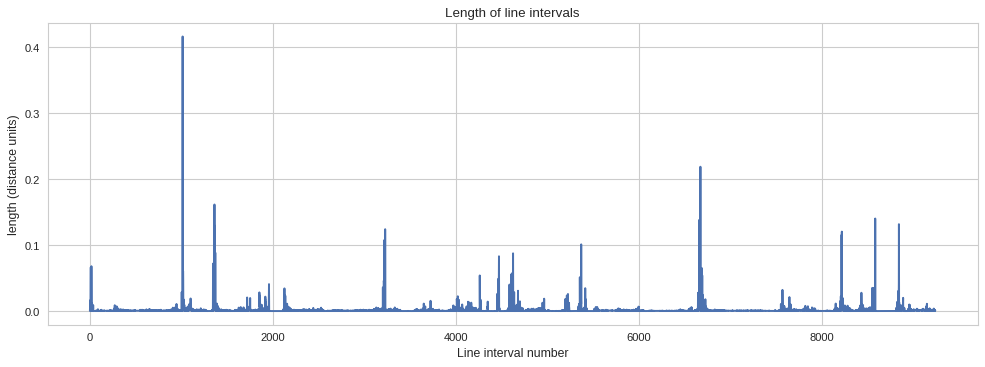

In [113]:
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([length(x) for x in lines])
plt.ylabel('length (distance units)')
plt.xlabel('Line interval number')
plt.title('Length of line intervals')

# Improving Path

In [114]:
FS = H
STEP = 0.01

NUM = 1000

START_X = -124
END_X = -122

START_Y = 48.2
END_Y = 49.7

dx = (END_X - START_X)/NUM
dy = (END_Y - START_Y)/NUM

# Point -> (Int, Int) or False
# get i,j indices in the feasible set from coordinates
def getIJ(point):
    if point[0] < START_X + 2*dx or point[0] > END_X - 2*dx:
        return False
    if point[1] < START_Y + 2*dy or point[1] > END_Y - 2*dy:
        return False
    
    return (int((point[0] - START_X)/dx), int((point[1] - START_Y)/dy))

def ijToPos(ij):
    i = ij[0]
    j = ij[1]
    return (i*dx + START_X, j*dy + START_Y)

# Point -> Boolean
# produce true if point is in the feasible set
def isFeasible(point):
    result = getIJ(point)
    if result:
        return 1 == FS[result[0], result[1]]
    else:
        return False
    
# Point, Point -> [Point]
# Get points near point, and ignore the ignore point
def getPointsNear(point, ignore, d):
    ij = getIJ(point)
    if not ij:
        return []
    
    ignore = getIJ(ignore)
    
    points = []
    if (FS[ij[0]+1, ij[1]] == 1):
        points.append((ij[0]+1, ij[1]))
    if FS[ij[0]-1, ij[1]] == 1:
        points.append((ij[0]-1, ij[1]))
        
    if FS[ij[0], ij[1]+1] == 1:
        points.append((ij[0], ij[1]+1))
    if FS[ij[0], ij[1]-1] == 1:
        points.append((ij[0], ij[1]-1))
 
    if FS[ij[0]+1, ij[1]+1] == 1:
        points.append((ij[0]+1, ij[1]+1))
    if FS[ij[0]+1, ij[1]-1] == 1:
        points.append((ij[0]+1, ij[1]-1))
        
    if FS[ij[0]-1, ij[1]+1] == 1:
        points.append((ij[0]-1, ij[1]+1))
    if FS[ij[0]-1, ij[1]-1] == 1:
        points.append((ij[0]-1, ij[1]-1))
    
    if ignore in points:
        points.remove(ignore)
    
    return points
    

In [115]:
MAX_LINE_LENGTH = 0.001
MAX_ITER = 10000

STEP = 1e-5

# Line -> [Line]
def generateLines(line):
    out = []
    
    p = line[0]
    d = (line[1][0] - line[0][0], line[1][1] - line[0][1])
    d_mag = math.sqrt(d[0] ** 2 + d[1] ** 2)
    d_norm = (d[0]/d_mag, d[1]/d_mag)
    d_step = (d_norm[0] * STEP, d_norm[1] * STEP)
    
    next_p = (p[0] + d_step[0], p[1] + d_step[1])
    next_line = (p, next_p)
    residual = (next_p, line[1])
    
    visited = set() # visited cells
    
    i = 0
    while length(residual) > MAX_LINE_LENGTH and i < MAX_ITER:
        i += 1
        next_p = (p[0] + d_step[0], p[1] + d_step[1])
        
        # Try to find the right way
        if not isFeasible(next_p):
            points = getPointsNear(next_p, p, d_step)
            points = list(set(points) - visited)
            if points:
                point = random.choice(points)
                visited.add(point)
                next_p = ijToPos(point)
            
        out.append((p, next_p))
        residual = (next_p, line[1])
        p = next_p
    
    return out

lines_improved = []
for line in lines:
    if length(line) > MAX_LINE_LENGTH:
        lines_improved.extend(generateLines(line)) # replace line by a sequence of line segments
    else:
        lines_improved.append(line)

In [116]:
print(len(lines), len(lines_improved))

9243 1136967


Text(0.5,1,'Length of Improved Line Intervals')

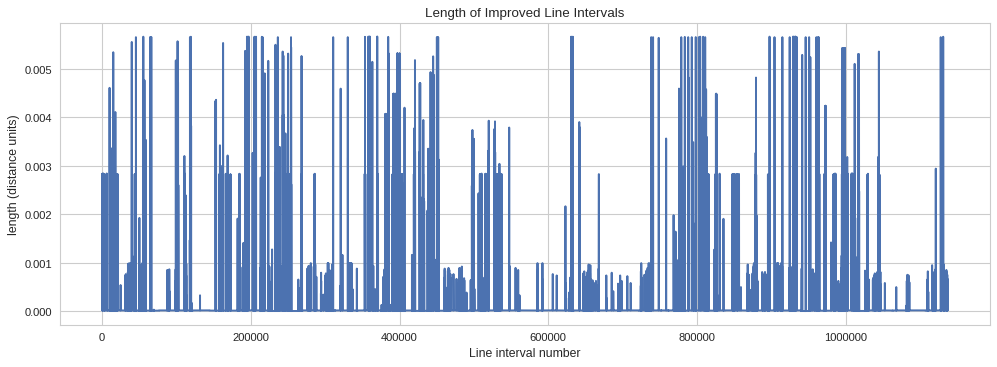

In [117]:
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([length(x) for x in lines_improved])
plt.ylabel('length (distance units)')
plt.xlabel('Line interval number')
plt.title('Length of Improved Line Intervals')

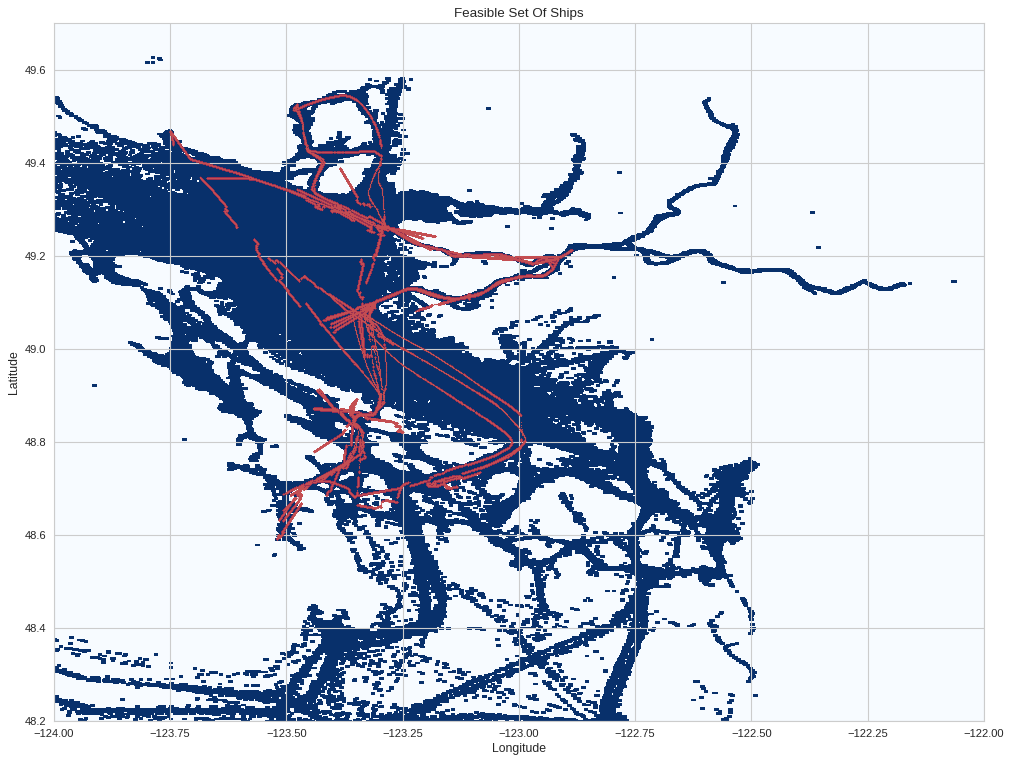

In [118]:
points_x2 = list(zip(*lines_improved))
points = points_x2[0]
l = list(zip(*points))
x = l[0]
y = l[1]

fig = plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, xlabel="Longitude", ylabel="Latitude", title="Feasible Set Of Ships")
plt.imshow(H, interpolation='nearest', origin='low',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap=mpl.cm.Blues)

plt.scatter(x,y, marker='.', color='r', s=2)